In [2]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from pathlib import Path
import holoviews as hv
import pymaster as nmt
import hvplot
import hvplot.xarray 
import xarray as xa
import panel as pn
import tensorflow as tf
import glob
import imageio
import os
import PIL
import time
import h5py
import began
from began.logging import setup_vae_run_logging
from IPython import display
from began.visualization import mplot, plot
%matplotlib inline
print("Working with GPU: ", tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Working with GPU:  True


In [3]:
DATA_DIR = Path("/oasis/scratch/comet/bthorne/temp_project/flat-maps")

In [4]:
zarr_record = DATA_DIR / "mhd.zarr"
data = xa.open_zarr(str(DATA_DIR / "mhd.zarr"))

In [13]:
train_images = data['data'].sel(zmin=200, pol=['q', 'u']).stack(batch=('direc', 'time')).transpose('batch', 'x', 'y', 'pol').values
print(train_images.shape)
nsamps = train_images.shape[0]
print(nsamps)

(1150, 256, 256, 2)
1150


In [5]:
hyperparameters = {
    'LAT_DIM': 64,
    'BATCH_SIZE': 32,
    'EPOCHS': 400,
    'NUM_EXAMPLES_TO_GENERATE': 4,
}

train_dataset = tf.data.Dataset.from_tensor_slices(train_images[:1000]).shuffle(1000).batch(hyperparameters['BATCH_SIZE'])
test_dataset = tf.data.Dataset.from_tensor_slices(train_images[1000:]).batch(hyperparameters['BATCH_SIZE'])

In [6]:
nsamps = 0
for train_data in train_dataset:
    nsamps += train_data.shape[0]
print(nsamps)

nsamps = 0
for train_data in test_dataset:
    nsamps += train_data.shape[0]
print(nsamps)

1000
150


In [7]:
@tf.function
def compute_apply_gradients(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = began.vae.compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

def generate_and_save_images(model, epoch, test_input, title=None):
    predictions = model.sample(test_input)
    mean = np.mean(predictions)
    std = np.std(predictions)
    mplot(predictions[..., 0], extent=(-10, 10, -10, 10), title=title, cbar_range=[mean - 2*std, mean+2*std])
    fig = plt.gcf()
    fig.savefig('plots/vae/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [8]:
optimizer = tf.keras.optimizers.Adam(beta_1=0.5, learning_rate=0.0002)
model = began.CVAE(hyperparameters['LAT_DIM'], 5)

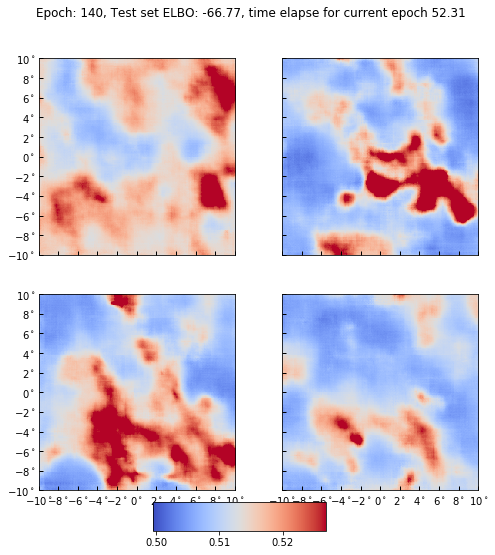

Epoch:  141
0
10
20
30
Epoch:  142
0
10
20
30
Epoch:  143
0
10
20
30
Epoch:  144
0
10
20
30
Epoch:  145
0
10
20
30
Epoch:  146
0
10
20
30
Epoch:  147
0
10
20
30
Epoch:  148
0
10
20
30
Epoch:  149
0
10
20
30
Epoch:  150
0


KeyboardInterrupt: 

In [9]:
# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(shape=[hyperparameters['NUM_EXAMPLES_TO_GENERATE'], hyperparameters['LAT_DIM']])

for epoch in range(1, hyperparameters['EPOCHS'] + 1):
    print("Epoch: ", epoch)
    start_time = time.time()
    for step, train_x in enumerate(train_dataset):
        if step % 10 == 0: 
            print(step)
        compute_apply_gradients(model, train_x, optimizer)

    end_time = time.time()
    
    if epoch % 10 == 0:
        loss = tf.keras.metrics.Mean()
        for test_x in test_dataset:
            loss(began.vae.compute_loss(model, test_x))
            print(loss)
        elbo = - loss.result()
        display.clear_output(wait=False)

        #with summary_writer.as_default():
        #    tf.summary.scalar('elbo', elbo, step=epoch)

        title = 'Epoch: {:03d}, Test set ELBO: {:04.02f}, time elapse for current epoch {:02.02f}'.format(epoch, elbo, end_time - start_time)
        generate_and_save_images(model, epoch, random_vector_for_generation, title)